In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# pl.rcParams['savefig.dpi'] = 300 # dpi for most publications
# pl.rcParams['xtick.labelsize'] = 7
# pl.rcParams['ytick.labelsize'] = 7
# pl.rcParams['axes.labelsize'] = 7

# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
NOTEBOOK_NAME = 'lambo_sessions'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
# load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [6]:
sessions = ['pre', 'post', 'ext1', 'ext2', 'renew']

for sess in sessions:
    exec("vars_%s = {}"%sess)
    folder = '../%s/notebooks/autorestore/preprocessing/'%sess
    try:
        for var in ('time_ax', 'licks', 'is_CSmt', 'is_rewardt', 'odor_CSm_ons', 'odor_rw_ons',
                    'CS_DURATION', 'CYCLE_START', 'CYCLE_DURATION', 'DELAY'): 
            eval("vars_%s"%sess).update({var:ut.load_variable(var, folder=folder)})
    except IOError:
        print "Nope %s"%sess

In [7]:
def plot_licks(tone_onsets, licks, CYCLE_START, CYCLE_DURATION, ax=None):
    if ax is None:
        fig, ax = pl.subplots(1, 1)
    for i, tone_ons in enumerate(tone_onsets):
        lick_filt = ((licks-tone_ons)>CYCLE_START) * ((licks-tone_ons)<CYCLE_DURATION)
        ax.vlines((licks-tone_ons)[lick_filt], i, i+1, lw=0.5)
    return ax

In [8]:
def plot_panel(axs, var, titles=False):
    plot_licks(var['odor_CSm_ons'], var['licks'], var['CYCLE_START'], var['CYCLE_DURATION'], ax=axs[0])
    if titles: axs[0].set_title('CS-')
    plot_licks(var['odor_rw_ons'], var['licks'], var['CYCLE_START'], var['CYCLE_DURATION'], ax=axs[1])
    if titles: axs[1].set_title('CS+')
    for c, ax in zip(['r', 'g'], axs):
        ax.set_xlim(var['CYCLE_START'], var['CYCLE_START']+var['CYCLE_DURATION'])
        pt.plot_period_bar(ax, -1, color=c, start_end=(0, var['CS_DURATION']), alpha=0.2, zorder=0,
                           delta_y=len(var['odor_CSm_ons']))
        pt.plot_period_bar(ax, -1, color='0.7', start_end=(var['CS_DURATION'], var['CS_DURATION']+var['DELAY']),
                           delta_y=len(var['odor_rw_ons']), alpha=0.2, zorder=0)
        ax.set_ylim(-2, len(var['odor_CSm_ons']))
        ax.set_xlim(-3, 10)
        pt.nicer_plot(ax)


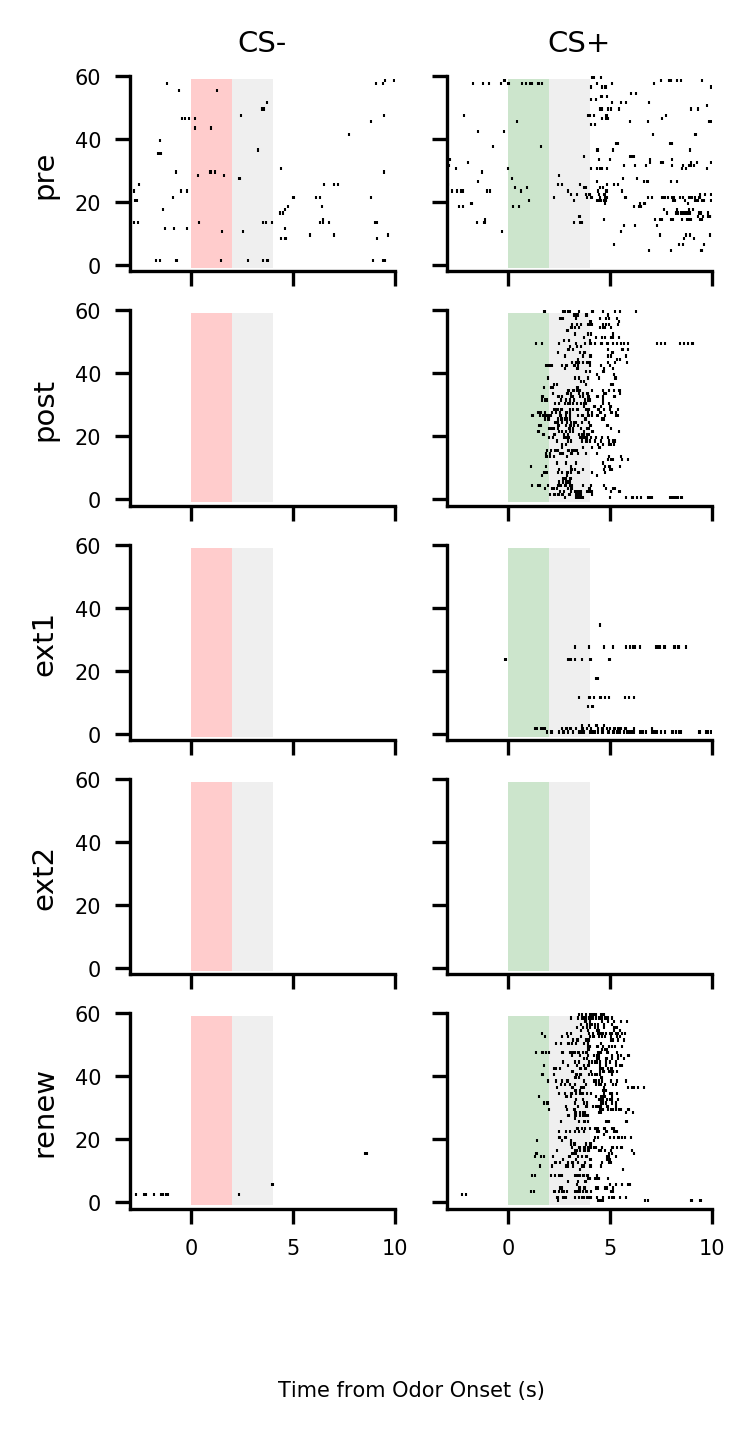

In [9]:
fig, axs = pl.subplots(len(sessions), 2, figsize=(2.5, len(sessions)), sharey=True, sharex=True)
for i, sess in enumerate(sessions):
    if len(eval('vars_%s'%sess))>0:
        plot_panel(axs[i], eval('vars_%s'%sess), titles=True if i==0 else False)
        axs[i][0].set_ylabel(sess)
fig.text(0.5, 0, 'Time from Odor Onset (s)', ha='center')
# fig.savefig("../img/lambo_d1d2d3.pdf")

In [10]:
vals_cs_CSmt = [[((eval("vars_%s"%sess)['licks']<(ons+eval("vars_%s"%sess)['CS_DURATION']))*
                (eval("vars_%s"%sess)['licks']>=(ons))).sum()*1./eval("vars_%s"%sess)['CS_DURATION'] 
              for ons in eval("vars_%s"%sess)['odor_CSm_ons']]
              for sess in sessions if len(eval("vars_%s"%sess))>0]
vals_cs_rewardt = [[((eval("vars_%s"%sess)['licks']<(ons+eval("vars_%s"%sess)['CS_DURATION']))*
                (eval("vars_%s"%sess)['licks']>=(ons))).sum()*1./eval("vars_%s"%sess)['DELAY']
                 for ons in eval("vars_%s"%sess)['odor_rw_ons']]
              for sess in sessions if len(eval("vars_%s"%sess))>0]

In [11]:
vals_CSmt = [[((eval("vars_%s"%sess)['licks']<(ons+eval("vars_%s"%sess)['CS_DURATION']+eval("vars_%s"%sess)['DELAY']))*
                (eval("vars_%s"%sess)['licks']>=(ons+eval("vars_%s"%sess)['CS_DURATION']))).sum()*1./eval("vars_%s"%sess)['DELAY'] 
              for ons in eval("vars_%s"%sess)['odor_CSm_ons']]
              for sess in sessions if len(eval("vars_%s"%sess))>0]
vals_rewardt = [[((eval("vars_%s"%sess)['licks']<(ons+eval("vars_%s"%sess)['CS_DURATION']+eval("vars_%s"%sess)['DELAY']))*
                (eval("vars_%s"%sess)['licks']>=(ons+eval("vars_%s"%sess)['CS_DURATION']))).sum()*1./eval("vars_%s"%sess)['DELAY']
                 for ons in eval("vars_%s"%sess)['odor_rw_ons']]
              for sess in sessions if len(eval("vars_%s"%sess))>0]

In [12]:
from scipy import stats as sstats

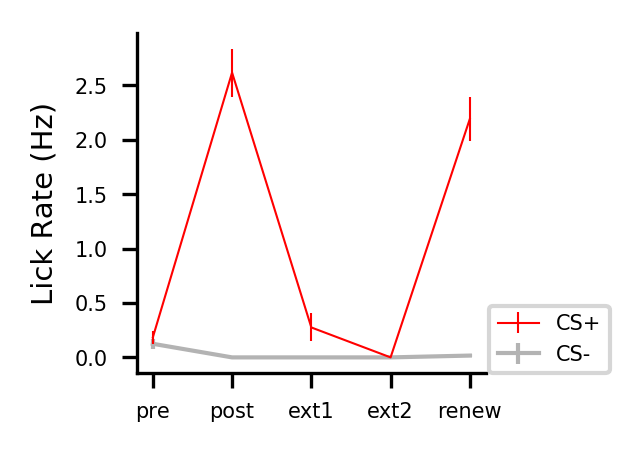

In [13]:
fig, ax = pl.subplots(1, 1, figsize=(1.5, 1.5))
pt.nicer_plot(ax)

m = np.mean(vals_rewardt, 1)
s = sstats.sem(vals_rewardt, 1)
ax.errorbar(range(len(vals_rewardt)), m, s, color='r', zorder=19)

m = np.mean(vals_CSmt, 1)
s = sstats.sem(vals_CSmt, 1)
ax.errorbar(range(len(vals_CSmt)), m, s, color='0.7', lw=1)

ax.legend(['CS+', 'CS-'], loc=(1.01, 0))
ax.set_xticks(range(len(sessions)))
ax.set_xticklabels(sessions)
ax.set_ylabel('Lick Rate (Hz)')

# ax.set_ylim(0, 3)

fig.savefig("../img/%s__lickrates.pdf"%NOTEBOOK_NAME)

In [14]:
save_workspace(db)

Could not store variable 'ip'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'os'. Skipping...
